In [1]:
import pdb
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pickle
import pandas as pd
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from dca.methods_comparison import JPCA 
sys.path.append('./analysis_scripts/turnkey/')
sys.path.append('/home/marcush/projects/github_repos/')
from config import PATH_DICT
from region_select import *
from sklearn.model_selection import KFold

import PSID.PSID as PSID
from PSID.evaluation import evalPrediction
from decoders import expand_state_space
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
def runPSID(decoding_df, session_key, data_path, region, recompute=True):

    failure_count = 0

    if recompute:

        fold_idcs = np.unique(decoding_df['fold_idx'].values)
        sessions = np.unique(decoding_df[session_key].values)
        dims = np.unique(decoding_df['dim'].values)

        fold_idcs = fold_idcs[:2]
        sessions = sessions[:2]
        dims = dims[:15]

        num_lag_steps = 3 #i: the number of block-rows (i.e. future and past horizon). 
        all_results = []

        for sess_ind, session in enumerate(sessions):

            if region == 'HPC':
                loader_args = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
            else:
                loader_args = decoding_df.iloc[0]['loader_args']

            if region in ['AM', 'ML']:  
                dat = load_data(data_path, region, session, loader_args, full_arg_tuple=decoding_df['full_arg_tuple'])
            else:
                dat = load_data(data_path, region, session, loader_args)

            y = dat['spike_rates'].squeeze()
            z = dat['behavior']

            # Don't do this for datasets that aren't M1, S1 (velocity/acc wont be relevant for other datasets)
            if region in ['M1', 'S1']:
                z, y = expand_state_space([z], [y])
                z = z[0]
                y = y[0]

            default_i = 5 if region in ["M1", "S1"] else 2


            print(f"Starting Session {sess_ind} of {len(sessions)}")
            for dim_ind, dim in tqdm(enumerate(dims)):
                for fidx, (train_idxs, test_idxs) in enumerate(KFold(n_splits=len(fold_idcs)).split(y)):

                    # Run PSID on raw firing rates
                    ytrain = y[train_idxs]
                    ytest = y[test_idxs]
                    ztrain = z[train_idxs]
                    ztest = z[test_idxs]                    

                    """ Contraint on i in relation to other vars:
                    n1/nz <= i
                    nx/ny <= i
                    """
                    nz = ztrain.shape[1]
                    ny = ytrain.shape[1]
                    nx=dim
                    n1=dim
 
                    i = int(np.ceil(max(n1/nz, nx/ny, default_i)))
                    try:
                        idsys = PSID(ytrain, ztrain, nx=nx, n1=n1, i=i)
                        zpred, _, _ = idsys.predict(ytest)
                        r2 = r2_score(ztest, zpred, multioutput='raw_values')
                    except: # Some strangeness here...
                        failure_count += 1
                        r2 = np.nan


                    # Run PSID on PCA projected firing rates
                    df_filter = {session_key:session, 'dim':dim, 'dimreduc_method':'PCA', 'fold_idx':fidx}
                    df = apply_df_filters(decoding_df, **df_filter)
                    assert(df.shape[0] == 1)
                    ytrain_pca = ytrain @ df.iloc[0]['coef'][:, 0:dim]             
                    ytest_pca = ytest @ df.iloc[0]['coef'][:, 0:dim]  
                    nz = ztrain.shape[1]
                    ny = ytrain_pca.shape[1]
                    nx=dim
                    n1=dim
                    i = int(np.ceil(max(n1/nz, nx/ny, default_i)))
                    idsys = PSID(ytrain_pca, ztrain, nx=nx, n1=n1, i=i)                        
                    zpred, _, _ = idsys.predict(ytest_pca)
                    r2_pca = r2_score(ztest, zpred, multioutput='raw_values')

                    # Run PSID on FCCA projected firing rates
                    df_filter = {session_key:session, 'dim':dim, 'dimreduc_method':['LQGCA', 'FCCA'], 'fold_idx':fidx}
                    df = apply_df_filters(decoding_df, **df_filter)
                    assert(df.shape[0] == 1)
                    ytrain_fca = ytrain @ df.iloc[0]['coef'][:, 0:dim]             
                    ytest_fca = ytest @ df.iloc[0]['coef'][:, 0:dim]  
                    nz = ztrain.shape[1]
                    ny = ytrain_pca.shape[1]
                    nx=dim
                    n1=dim
                    i = int(np.ceil(max(n1/nz, nx/ny, default_i)))
                    idsys = PSID(ytrain_fca, ztrain, nx=nx, n1=n1, i=i)
                    zpred, _, _ = idsys.predict(ytest_fca)
                    r2_fca = r2_score(ztest, zpred, multioutput='raw_values')

                    # Save structs
                    result = {}
                    result['session'] = session
                    result['dim'] = dim
                    result['fidx'] = fidx
                    result['r2'] = r2
                    result['r2_pca'] = r2_pca
                    result['r2_fca'] = r2_fca
                    all_results.append(result)


        all_results_df = pd.DataFrame(all_results)

        #tmp_root_path = PATH_DICT['tmp']
        #with open(f'{tmp_root_path}/psid_df_{region}.pkl', 'wb') as f:
        #    f.write(pickle.dumps(all_results_df))


    else:
        tmp_root_path = PATH_DICT['tmp']
        with open(f'{tmp_root_path}/psid_df_{region}.pkl', 'rb') as f:
            all_results_df = pickle.load(f)


    print(f"Total Failures: {failure_count}")
    return all_results_df


In [5]:
def plotPSID(all_results_df, region):

    sessions = np.unique(all_results_df['session'])
    dims = np.unique(all_results_df['dim'])
    folds = np.unique(all_results_df['fidx'])
        

    # PSID r2
    psid_r2_mat = np.zeros((sessions.size, dims.size, folds.size, 3))
    for i, session in tqdm(enumerate(sessions)):
        for j, dim in enumerate(dims):               
            for f in folds:
                dim_fold_df = apply_df_filters(all_results_df, session=session, dim=dim, fidx=f)
                #psid_r2_f[i, j, f] = np.mean(dim_fold_df.iloc[0]['r2'][2:4])
                psid_r2_mat[i, j, f, 0] = np.mean(dim_fold_df.iloc[0]['r2'])
                psid_r2_mat[i, j, f, 1] = np.mean(dim_fold_df.iloc[0]['r2_pca'])
                psid_r2_mat[i, j, f, 2] = np.mean(dim_fold_df.iloc[0]['r2_fca'])


    psid_r2 = np.mean(psid_r2_mat[:, :, :, 0], axis=2)
    pca_r2 = np.mean(psid_r2_mat[:, :, :, 1], axis=2)
    fca_r2 = np.mean(psid_r2_mat[:, :, :, 2], axis=2)



    fig, ax = plt.subplots(figsize=(4, 4))
    colors = ['black', 'red', '#781820', '#5563fa']

    norm_factor = 215
    ax.fill_between(dims, np.mean(fca_r2, axis=0) + np.std(fca_r2, axis=0)/np.sqrt(norm_factor),  np.mean(fca_r2, axis=0) - np.std(fca_r2, axis=0)/np.sqrt(norm_factor), color=colors[1], alpha=0.25, label='_nolegend_')
    ax.plot(dims, np.mean(fca_r2, axis=0), color=colors[1])

    ax.fill_between(dims, np.mean(pca_r2, axis=0) + np.std(pca_r2, axis=0)/np.sqrt(norm_factor), np.mean(pca_r2, axis=0) - np.std(pca_r2, axis=0)/np.sqrt(norm_factor), color=colors[0], alpha=0.25, label='_nolegend_')
    ax.plot(dims, np.mean(pca_r2, axis=0), color=colors[0])

    ax.fill_between(dims, np.mean(psid_r2, axis=0) + np.std(psid_r2, axis=0)/np.sqrt(norm_factor),  np.mean(psid_r2, axis=0) - np.std(psid_r2, axis=0)/np.sqrt(norm_factor), color=colors[2], alpha=0.25, label='_nolegend_')
    ax.plot(dims, np.mean(psid_r2, axis=0), color=colors[2])


    ax.set_xlabel('Dimension', fontsize=18)
    if region in ['M1', 'S1']:
        ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=18)
    elif region == 'HPC':
        ax.set_ylabel('Position Decoding ' + r'$r^2$', fontsize=18)


    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(['FCCA+PSID', 'PCA+PSID', 'PSID'], fontsize=10, frameon=False, loc='lower right')

    
    #fig.savefig(f"{PATH_DICT['figs']}/psid_decoding_{region}.pdf", bbox_inches='tight', pad_inches=0)


Starting Session 0 of 2


1it [00:00,  1.54it/s]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


2it [00:11,  6.38s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


3it [00:21,  8.42s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


4it [00:32,  9.37s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


5it [00:44, 10.08s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


6it [00:54, 10.37s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


7it [01:05, 10.57s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


8it [01:16, 10.46s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


9it [01:27, 10.62s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


10it [01:37, 10.63s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


11it [01:48, 10.78s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


12it [01:59, 10.77s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman


/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/PSID/LSSM.py:144: RuntimeWarning: overflow encountered in matmul
  ziCov = self.C @ Pp @ self.C.T + self.R
13it [02:03,  8.57s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


14it [02:14,  9.34s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman


/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/PSID/LSSM.py:144: RuntimeWarning: overflow encountered in matmul
  ziCov = self.C @ Pp @ self.C.T + self.R
15it [02:16,  9.12s/it]


Starting Session 1 of 2


1it [00:00,  1.41it/s]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


2it [00:09,  5.68s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


3it [00:18,  7.24s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


4it [00:28,  7.96s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


5it [00:37,  8.41s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


6it [00:46,  8.75s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


7it [00:56,  9.00s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


8it [01:05,  9.12s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


9it [01:15,  9.26s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


10it [01:24,  9.37s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


11it [01:34,  9.49s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


12it [01:44,  9.57s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


13it [01:54,  9.69s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


14it [02:04,  9.87s/it]

Could not solve DARE
Steady state Kalman gain not available. Will perform non-steady-state Kalman
Steady state Kalman gain not available. Will perform non-steady-state Kalman


15it [02:14,  8.99s/it]


Total Failures: 2


2it [00:00, 32.13it/s]


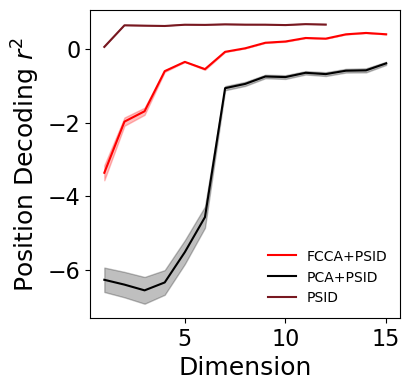

In [6]:
#regions = ['M1', 'S1', 'M1_maze', 'HPC']
regions = ['HPC'] 
for region in regions:

    figpath = PATH_DICT['figs']
    data_path = get_data_path(region)
    df, session_key = load_decoding_df(region, **loader_kwargs[region])

    all_results_df = runPSID(df, session_key, data_path, region, recompute=True)

    plotPSID(all_results_df, region)
